Import libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import zipfile

Unzipping the files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/Melanoma_Detection_Assignment/CNN_assignment.zip", 'r')
#zip_ref.extractall("/CNN_Assignment")
#zip_ref.close()
!unzip /content/gdrive/MyDrive/Melanoma_Detection_Assignment/CNN_assignment.zip

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/Melanoma_Detection_Assignment/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaborat

In [ ]:
data_training = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_testing = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_training.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_testing.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load the images using Keras.preprocessing

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_training,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
validate_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_training,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
class_names = training_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualizing the training , validation data

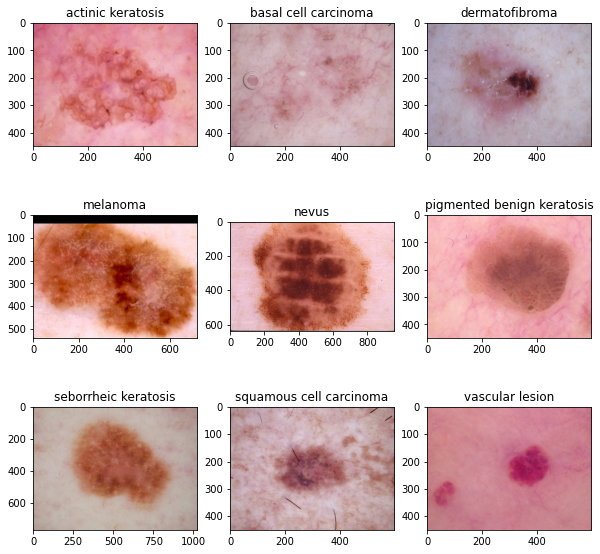

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_training.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validate_ds = validate_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating the model

In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

Compiling the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                    

### Training the model

In [ ]:
epochs = 20
history = model.fit(
  training_ds,
  validation_data=validate_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 496s 9s/step - loss: 2.0430 - accuracy: 0.2020 - val_loss: 1.9800 - val_accuracy: 0.2438
Epoch 2/20
56/56 [==============================] - 479s 9s/step - loss: 1.9821 - accuracy: 0.2249 - val_loss: 1.8964 - val_accuracy: 0.3221
Epoch 3/20
56/56 [==============================] - 479s 9s/step - loss: 1.9930 - accuracy: 0.2405 - val_loss: 1.9083 - val_accuracy: 0.2841
Epoch 4/20
56/56 [==============================] - 477s 9s/step - loss: 1.8342 - accuracy: 0.3125 - val_loss: 1.7536 - val_accuracy: 0.3445
Epoch 5/20
56/56 [==============================] - 478s 9s/step - loss: 1.7062 - accuracy: 0.3677 - val_loss: 1.5954 - val_accuracy: 0.4116
Epoch 6/20
56/56 [==============================] - 478s 9s/step - loss: 1.6588 - accuracy: 0.4090 - val_loss: 1.7382 - val_accuracy: 0.3781
Epoch 7/20
56/56 [==============================] - 478s 9s/step - loss: 1.5997 - accuracy: 0.4191 - val_loss: 1.5746 - val_accuracy: 0.4318
Epoch 8/20
56/56 [======

Visualizing the trainied results

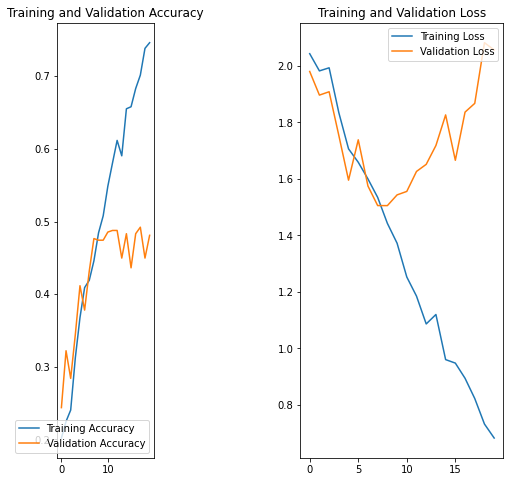

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

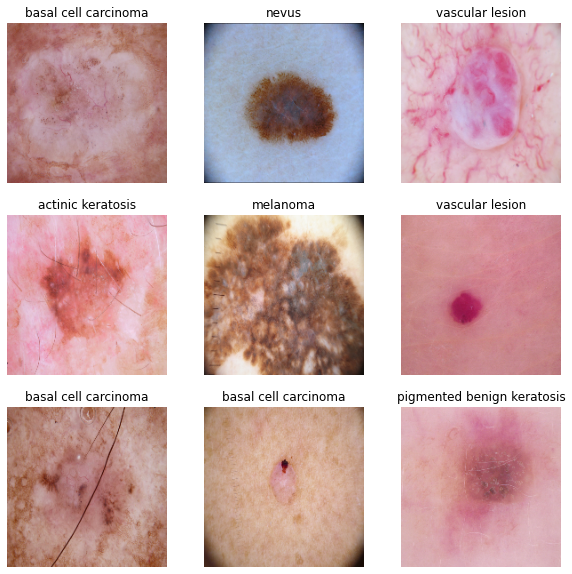

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, labels in training_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


In [ ]:
### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 20
history = model.fit(
  training_ds,
  validation_data=validate_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 540s 10s/step - loss: 2.0626 - accuracy: 0.1758 - val_loss: 2.0204 - val_accuracy: 0.2260
Epoch 2/20
56/56 [==============================] - 540s 10s/step - loss: 2.0421 - accuracy: 0.1914 - val_loss: 2.0297 - val_accuracy: 0.1946
Epoch 3/20
56/56 [==============================] - 546s 10s/step - loss: 2.0223 - accuracy: 0.1914 - val_loss: 2.0213 - val_accuracy: 0.1946
Epoch 4/20
56/56 [==============================] - 544s 10s/step - loss: 2.0000 - accuracy: 0.2098 - val_loss: 1.9195 - val_accuracy: 0.2819
Epoch 5/20
56/56 [==============================] - 541s 10s/step - loss: 1.9486 - accuracy: 0.2578 - val_loss: 2.0464 - val_accuracy: 0.1633
Epoch 6/20
56/56 [==============================] - 539s 10s/step - loss: 1.9259 - accuracy: 0.2690 - val_loss: 1.8286 - val_accuracy: 0.3087
Epoch 7/20
56/56 [==============================] - 539s 10s/step - loss: 1.8206 - accuracy: 0.3164 - val_loss: 1.7357 - val_accuracy: 0.3244
Epoch 

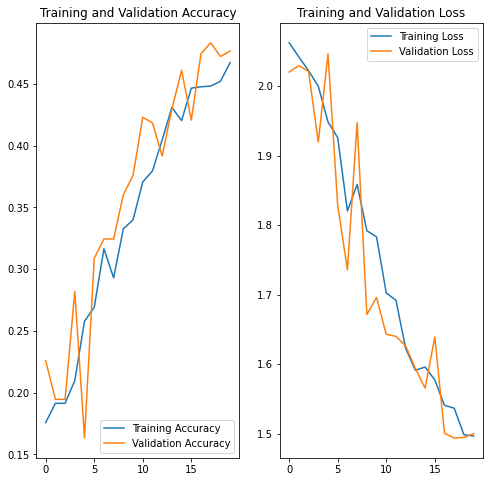

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
##
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_training.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [ ]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


<BarContainer object of 9 artists>

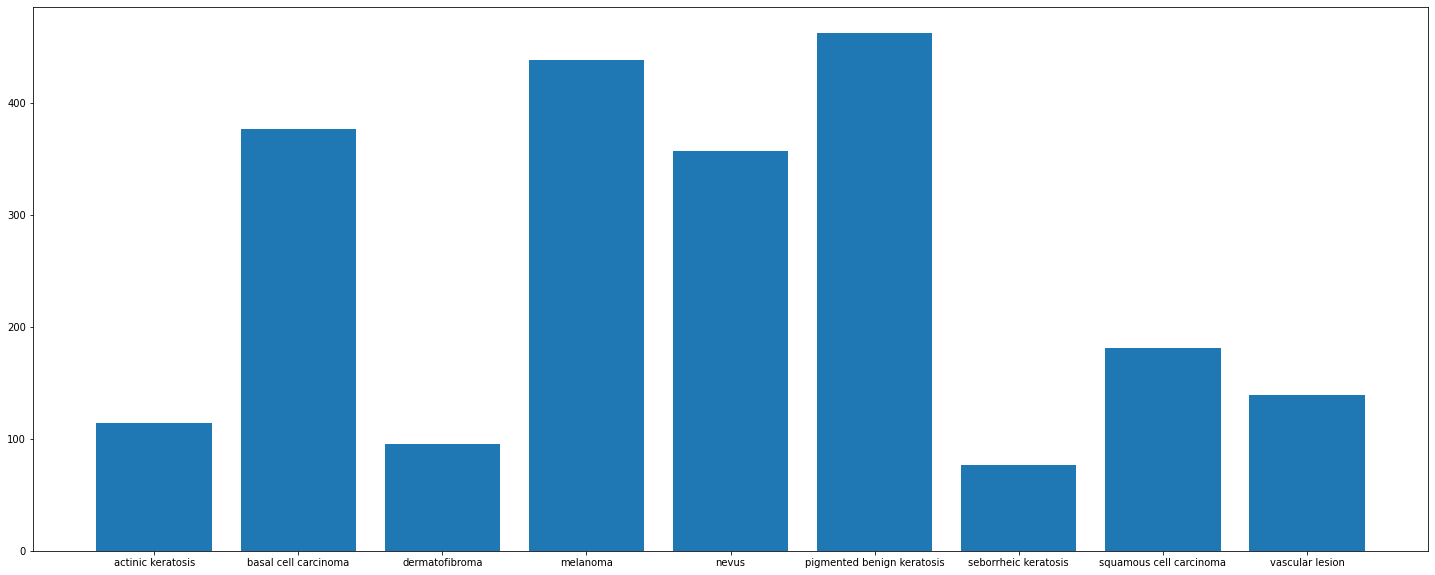

In [ ]:
count=[]
for i in class_names:
    count.append(len(list(data_training.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F79E7835050>: 100%|██████████| 500/500 [01:02<00:00,  8.05 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F79E7D2E5D0>: 100%|██████████| 500/500 [00:56<00:00,  8.84 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F79E7CC3C50>: 100%|██████████| 500/500 [00:47<00:00, 10.51 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F79E780C150>: 100%|██████████| 500/500 [00:56<00:00,  8.82 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7F79E6476C90>: 100%|██████████| 500/500 [00:55<00:00,  9.08 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F79E64F65D0>: 100%|██████████| 500/500 [01:01<00:00,  8.16 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F79E77F1B90>: 100%|██████████| 500/500 [00:53<00:00,  9.33 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F79E709AE10>: 100%|██████████| 500/500 [00:48<00:00, 10.22 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F79E7BABD50>: 100%|██████████| 500/500 [00:47<00:00, 10.46 Samples/s]


In [ ]:
data_dir_train1 = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [ ]:
##
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
6734,/content/Skin cancer ISIC The International Sk...,vascular lesion
6735,/content/Skin cancer ISIC The International Sk...,vascular lesion
6736,/content/Skin cancer ISIC The International Sk...,vascular lesion
6737,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [ ]:
new_df['Label'].value_counts()

melanoma                      1379
pigmented benign keratosis    1372
nevus                         1093
basal cell carcinoma          1082
squamous cell carcinoma        536
vascular lesion                423
actinic keratosis              337
dermatofibroma                 296
seborrheic keratosis           221
Name: Label, dtype: int64

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
import pathlib
#data_dir_train1=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/output")
data_dir_train1=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

In [ ]:
data_dir_train1

PosixPath('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

In [ ]:
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

2239


In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


data_dir_train1=pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [ ]:
## ### Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
epochs = 30
history = model.fit(
  training_ds,
  validation_data=validate_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 560s 10s/step - loss: 2.0899 - accuracy: 0.2009 - val_loss: 2.0491 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 544s 10s/step - loss: 2.0163 - accuracy: 0.2288 - val_loss: 1.9833 - val_accuracy: 0.2215
Epoch 3/30
56/56 [==============================] - 541s 10s/step - loss: 1.8728 - accuracy: 0.3092 - val_loss: 1.8355 - val_accuracy: 0.3579
Epoch 4/30
56/56 [==============================] - 543s 10s/step - loss: 1.7000 - accuracy: 0.3917 - val_loss: 1.5504 - val_accuracy: 0.4676
Epoch 5/30
39/56 [===================>..........] - ETA: 2:34 - loss: 1.5162 - accuracy: 0.4639